<a href="https://colab.research.google.com/github/is-leeroy-jenkins/Boo/blob/main/ipynb/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TAS Analytics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ( LinearRegression, Ridge, RidgeClassifier, LogisticRegression,
                                   BayesianRidge, SGDRegressor, SGDClassifier  )
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.datasets import make_classification
from sklearn.svm import SVR, SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor,
                            GradientBoostingClassifier, GradientBoostingRegressor, AdaBoostClassifier, AdaBoostRegressor)

from openai import OpenAI

import warnings

In [2]:
hdr = '\r\n' + '-' * 120 + '\r\n'
nwln = '\r\n'
warnings.filterwarnings( 'ignore' )

#### Data Source
- File A (Account Balances) published monthly by agencies on [USASpending](https://www.usaspending.gov/federal_account)
- Required by the DATA Act.
- Pulled automatically from data in the [Governmentwide Treasury Account Symbol Adjusted Trial Balance System (GTAS)](https://fiscal.treasury.gov/gtas/)
- Contains Budgetary resources, obligation, and outlay data for all the relevant Treasury Account Symbols (TAS) in a reporting agency.
- It includes both award and non-award spending (grouped together), and crosswalks with the [SF 133 report](https://portal.max.gov/portal/document/SF133/Budget/FACTS%20II%20-%20SF%20133%20Report%20on%20Budget%20Execution%20and%20Budgetary%20Resources.html).



### 📊 Descriptive Statistics
___
| Statistic         | Description                             | Use in Budget Analysis                                               |
|------------------|-----------------------------------------|----------------------------------------------------------------------|
| **Mean**         | Average value                           | Avg. `Outlays`, `Obligations`, etc., across accounts                |
| **Median**       | Middle value                            | Robust central tendency in skewed financial data                    |
| **Mode**         | Most frequent value                     | Identify common `MainAccountCodes` or `Availability` categories     |
| **Standard Deviation** | Spread around the mean                | Indicates variability in execution rates or balances                |
| **Variance**     | Square of standard deviation            | Used in statistical tests and model diagnostics                     |
| **Range**        | Difference between max and min          | Measures total spread of financial metrics                          |
| **Interquartile Range (IQR)** | Spread of middle 50% of data           | Identifies budget outliers and extreme accounts                     |
| **Skewness**     | Asymmetry of distribution               | Skewed obligations suggest few accounts dominate totals             |
| **Kurtosis**     | "Peakedness" of distribution            | High values indicate outlier-prone financial data                   |


### 🔍 Inferential Statistics
___
| Metric           | Description                                | Use in Budget Analysis                                                  |
|-------------------------|--------------------------------------------|--------------------------------------------------------------------------|
| **Pearson Correlation** | Linear relationship between variables      | E.g., `TotalResources` vs. `Obligations`                                |
| **Spearman Correlation**| Monotonic (rank-based) relationship        | More robust to non-linear trends in financial execution                 |
| **t-test**              | Compare means between 2 groups             | Discretionary vs. Mandatory accounts' execution rates                   |
| **ANOVA**               | Compare means across multiple groups       | `Obligations` across availability periods or account types              |
| **Chi-square Test**     | Categorical independence                   | Is `MainAccountCode` related to `Availability` or agency?              |
| **Confidence Intervals**| Estimate range of a population mean        | Bound expected obligations or recoveries                                |
| **Regression Coefficients (p-values)** | Test variable significance       | Is `Recoveries` a significant predictor of `UnobligatedBalance`?        |
| **F-statistic (overall regression)**   | Test whole model fit             | Determines joint explanatory power of all predictors                    |
| **Z-score / Outlier Tests** | Deviation from standard mean             | Identify abnormal balances or lapse rates                               |
| **Boxplots**            | Visual outlier detection                   | Show obligation anomalies within agencies                               |


### Balances Dataset

In [3]:
# Load the Excel file
file_path_balances = r'C:\Users\terry\Desktop\Account Balances.xlsx'
df_balances = pd.read_excel( file_path_balances, sheet_name = 'Data' )
numeric_columns = [ 'CarryoverAuthority', 'CarryoverAdjustments', 'AnnualAppropriations',
                    'BorrowingAuthority', 'ContractAuthority', 'OffsettingReceipts',
                    'Obligations', 'Recoveries', 'UnobligatedBalance', 'Outlays', 'TotalResources' ]
subset_columns = [ 'AnnualAppropriations', 'CarryoverAuthority', 'UnobligatedBalance',
                   'Obligations', 'Outlays' ]

# Filter data
all = [ 'AccountBalancesId', 'AgencyIdentifier', 'AgencyName', 'BeginningPeriodOfAvailability',
        'EndingPeriodOfAvailablity', 'Availability', 'MainAccountCode', 'SubAccountCode',
        'TreasuryAccountSymbol', 'TreasuryAccountName', 'BudgetFunction', 'BudgetSubFunction',
        'FederalAccountSymbol', 'FederalAccountName', 'LastModified',
        'SubmissionPeriod' ] + numeric_columns
subset = [ 'AgencyName', 'BudgetFunction' ] + subset_columns

# Define complete dataset
df_dataset = df_balances[ all ].fillna( 0 )
df_subset = df_balances[ subset ].fillna( 0 )

# Convert fiscal year columns to numeric
df_dataset.iloc[ :, 5: ] = df_dataset.iloc[ :, 5: ].apply( pd.to_numeric, errors = 'coerce' )

print( hdr )
print( 'Descriptive Statistics - Balances Dataset' )
print( nwln )

# Descriptive Statistics & Probability Distributions
df_descriptive = df_dataset[ numeric_columns ].describe( percentiles=[ .25, .5, .75 ] )

df_descriptive.round( 2 )


------------------------------------------------------------------------------------------------------------------------

Descriptive Statistics - Balances Dataset




,CarryoverAuthority,CarryoverAdjustments,AnnualAppropriations,BorrowingAuthority,ContractAuthority,OffsettingReceipts,Obligations,Recoveries,UnobligatedBalance,Outlays,TotalResources
count,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04
mean,2.236022e+08,1.670400e+07,9.640120e+08,5.143275e+06,2.341911e+07,5.658304e+07,1.044334e+09,2.671504e+07,2.451300e+08,1.002847e+09,1.289464e+09
std,4.410790e+09,9.209870e+08,1.926234e+10,3.624667e+08,1.010791e+09,1.118463e+09,1.907602e+10,6.600979e+08,4.591571e+09,1.872748e+10,1.995196e+10
min,-1.243823e+10,-1.069944e+11,-4.778902e+11,0.000000e+00,-1.653946e+07,-7.315833e+09,-9.230616e+06,-1.885326e+06,-2.344574e+10,-4.726972e+06,-4.288210e+09
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.680000e+00,7.901800e+02,9.932670e+04
50%,4.765065e+05,5.533000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.073116e+05,1.535033e+04,5.543914e+05,1.329503e+06,2.305069e+06
75%,6.926488e+06,7.500632e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.115899e+07,1.024507e+06,7.935946e+06,3.053774e+07,3.612729e+07
max,4.681363e+11,1.219471e+11,1.301902e+12,4.569707e+10,1.061979e+11,1.202509e+11,1.301902e+12,7.949705e+10,4.681363e+11,1.293782e+12,1.301902e+12


### Linear Regression


------------------------------------------------------------------------------------------------------------------------

Linear Regression




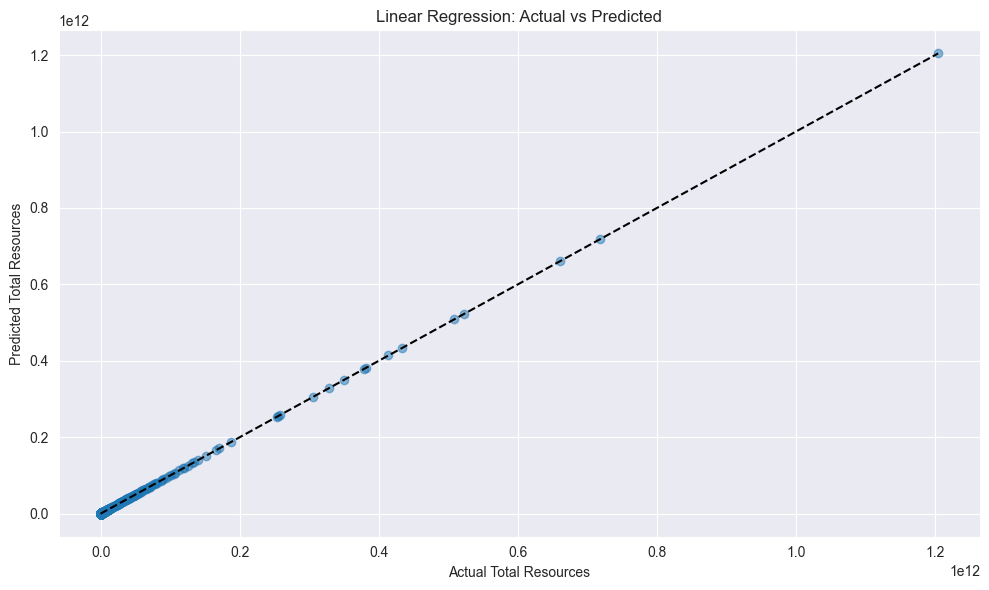

In [114]:
# Select features and target for linear regression
features = df_dataset[ [ 'AnnualAppropriations', 'Obligations', 'UnobligatedBalance', 'Outlays'  ] ]
target = df_dataset[ 'TotalResources' ]

# Train/test splits
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( features, target, random_state=42)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split( features, target,  random_state=42)

# Linear regression model
model = LinearRegression()
model.fit(X_train_reg, y_train_reg)
y_pred = model.predict(X_test_reg)

print( hdr )
print( 'Linear Regression' )
print( nwln )

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--')
plt.xlabel("Actual Total Resources")
plt.ylabel("Predicted Total Resources")
plt.title("Linear Regression: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()

###  🌳 Decision Tree Classifier: Confusion Matrix
- This confusion matrix summarizes the performance of a classification tree tasked with predicting whether Outlays are above or below the median.
- It recursively splits the feature space based on information gain (Gini impurity).
- The model performs discrete binary classification and provides easily interpretable decision rules.
- Misclassifications may arise from noise or overfitting, especially without regularization.


------------------------------------------------------------------------------------------------------------------------

Decision Tree Classifier




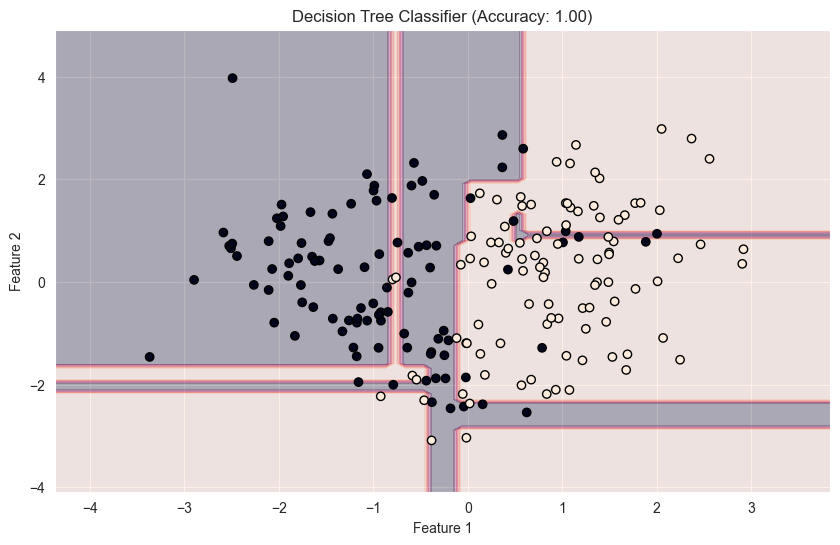

In [92]:
# Create a synthetic classification dataset
X_class, y_class = make_classification( n_samples=200, n_features=2, n_informative=2, n_redundant=0, random_state=42 )

# Train DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier( random_state=42 )
dt_classifier.fit( X_class, y_class )

# Predict and evaluate
y_pred_class = dt_classifier.predict( X_class )
accuracy = accuracy_score( y_class, y_pred_class )

# Plot decision boundary
xx, yy = np.meshgrid (np.arange( X_class[ :, 0 ].min( ) - 1, X_class[ :, 0 ].max( ) + 1, 0.1 ),
                     np.arange( X_class[ :, 1 ].min( ) - 1, X_class[ :, 1 ].max( ) + 1, 0.1 ) )
Z = dt_classifier.predict( np.c_[ xx.ravel( ), yy.ravel( ) ] )
Z = Z.reshape( xx.shape )

print( hdr )
print( 'Decision Tree Classifier' )
print( nwln )

plt.figure( figsize=( 10, 6 ) )
plt.contourf( xx, yy, Z, alpha=0.3 )
plt.scatter( X_class[ :, 0 ], X_class[ :, 1 ], c=y_class, edgecolor='k', marker='o' )
plt.title( f"Decision Tree Classifier (Accuracy: {accuracy:.2f})" )
plt.xlabel( "Feature 1" )
plt.ylabel( "Feature 2" )
plt.show( )

### 🌳 Decision Tree Regressor: Actual vs. Predicted
- This plot displays the predictions of a decision tree regression model trained on federal account-level financial data using TotalResources as the target.
- The tree partitions feature space into axis-aligned regions to minimize error in predicting continuous values.
- The vertical scatter seen in the plot reflects the model's nonlinear, piecewise-constant approximation behavior.
- It's interpretable and fast but may overfit if not pruned or tuned.


------------------------------------------------------------------------------------------------------------------------

Decision Tree Regressor




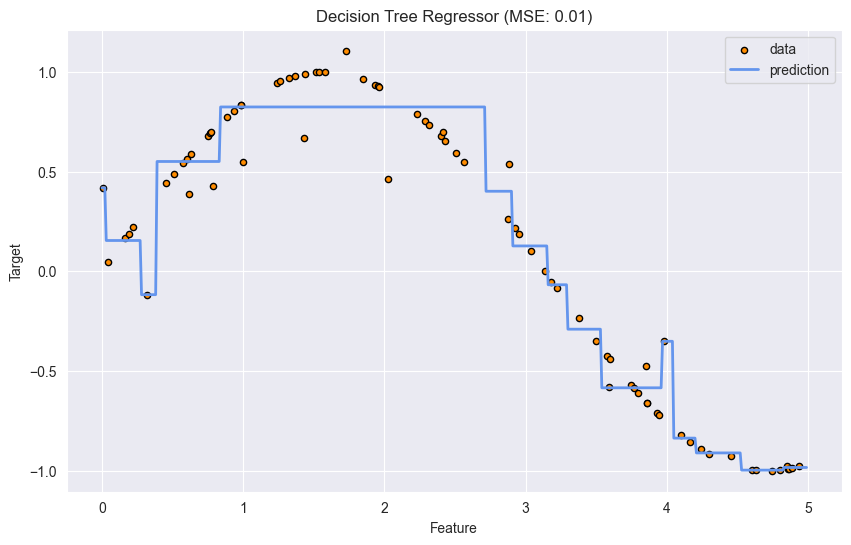

In [103]:
# Create a synthetic regression dataset
X_reg = np.sort( 5 * np.random.rand( 80, 1 ), axis=0 )
y_reg = np.sin( X_reg ).ravel( )

# Add noise to targets
y_reg[ ::5 ] += 1 * ( 0.5 - np.random.rand( 16 ) )

# Train DecisionTreeRegressor
dt_regressor = DecisionTreeRegressor( max_depth=4, random_state=42 )
dt_regressor.fit( X_reg, y_reg )

# Predict and evaluate
X_test_reg = np.arange( 0.0, 5.0, 0.01 )[ :, np.newaxis ]
y_pred_reg = dt_regressor.predict( X_test_reg )
mse = mean_squared_error( y_reg, dt_regressor.predict( X_reg ) )

print( hdr )
print( 'Decision Tree Regressor' )
print( nwln )

# Plot results
plt.figure( figsize=( 10, 6 ) )
plt.scatter( X_reg, y_reg, s=20, edgecolor="black", c="darkorange", label="data" )
plt.plot( X_test_reg, y_pred_reg, color="cornflowerblue", label="prediction", linewidth=2 )
plt.xlabel( "Feature" )
plt.ylabel( "Target" )
plt.title( f"Decision Tree Regressor (MSE: {mse:.2f})" )
plt.legend( )
plt.show( )

### 🌲 Random Forest Regressor: Actual vs. Predicted
- This scatterplot shows predictions from a Random Forest Regressor using TotalResources as the target.
- Combines predictions from 100 decision trees to reduce overfitting and improve generalization.
- Produces smooth, non-linear regression surfaces.
- Performs well with modest preprocessing and handles interactions between variables implicitly.


------------------------------------------------------------------------------------------------------------------------

Random Forest Regressor




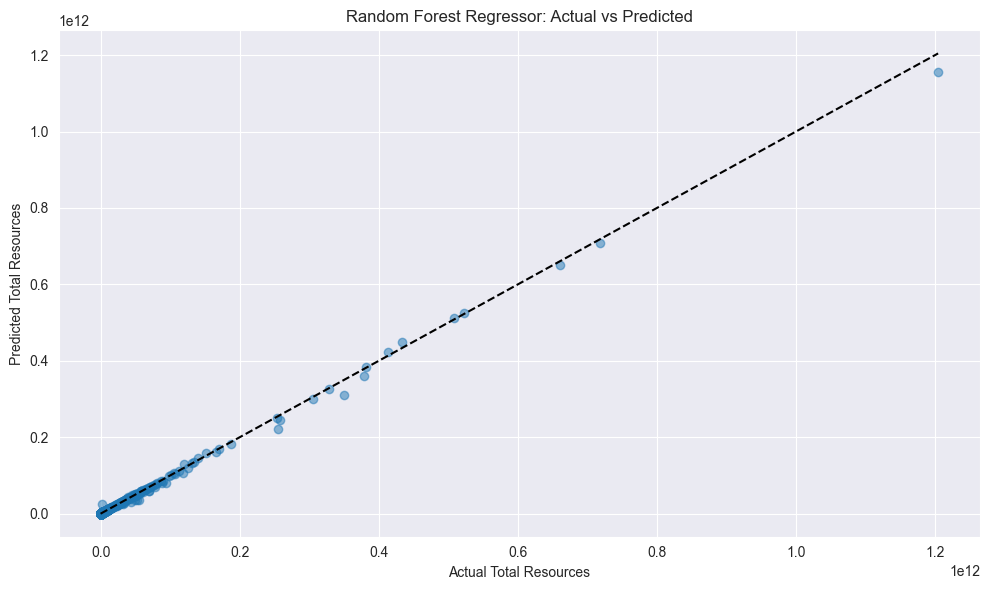

In [115]:
from sklearn.ensemble import RandomForestRegressor

# Train/test splits
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( features, target, random_state=42)

# RandomForestRegressor
rf_reg = RandomForestRegressor( n_estimators=100, random_state=42 )
rf_reg.fit(X_train_reg, y_train_reg)
y_pred_rf_reg = rf_reg.predict(X_test_reg)

print( hdr )
print( 'Random Forest Regressor' )
print( nwln )

plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_rf_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--')
plt.xlabel("Actual Total Resources")
plt.ylabel("Predicted Total Resources")
plt.title("Random Forest Regressor: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show( )



### 🌲 Random Forest Classifier: Confusion Matrix
- This confusion matrix reflects classification performance on predicting whether Outlays are above or below the median.
- Uses majority voting from 100 decision trees for classification.
- Robust to outliers and noise with high accuracy and feature importance insight.
- Diagonal values represent correct classifications.

In [122]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

# Train/test splits

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split( features, target  random_state=42)

# RandomForestClassifier
rf_cls = RandomForestClassifier( n_estimators=100, random_state=42 )
rf_cls.fit( X_train_class, y_train_class )

print( hdr )
print( 'Classifier' )
print( nwln )

plt.figure(figsize=(10, 6))
ConfusionMatrixDisplay.from_estimator( rf_cls, X_test_class, y_test_class, display_labels=['Below Median', 'Above Median'])
plt.title("Random Forest Classifier Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show( )


SyntaxError: invalid syntax. Perhaps you forgot a comma? (4173902008.py, line 6)

#### Extra Trees Classifier


------------------------------------------------------------------------------------------------------------------------

Classifier




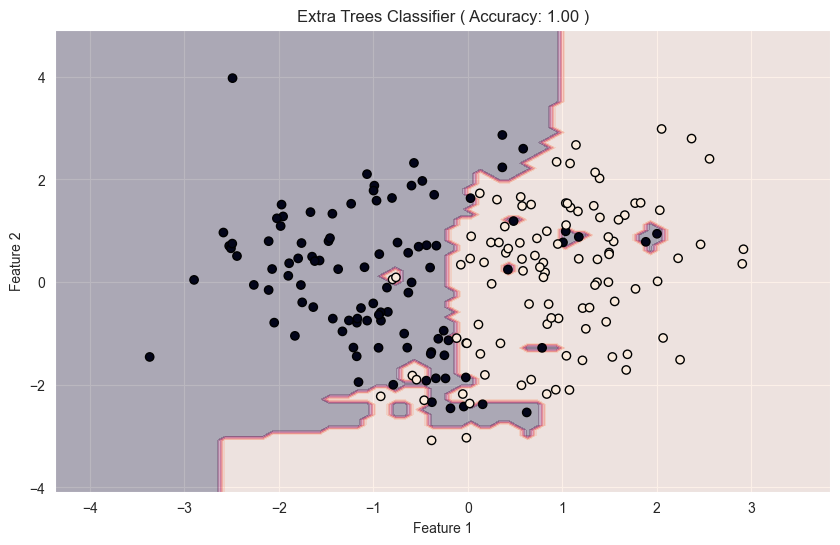

In [123]:
# Train ExtraTreesClassifier
et_classifier = ExtraTreesClassifier(n_estimators=100, random_state=42)
et_classifier.fit(X_class, y_class)

# Predict and evaluate
y_pred_et_class = et_classifier.predict(X_class)
accuracy_et = accuracy_score(y_class, y_pred_et_class)

# Plot decision boundary
Z_et = et_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z_et = Z_et.reshape(xx.shape)

print( hdr )
print( 'Classifier' )
print( nwln )

plt.figure( figsize=( 10, 6 ) )
plt.contourf(xx, yy, Z_et, alpha=0.3)
plt.scatter(X_class[:, 0], X_class[:, 1], c=y_class, edgecolor='k', marker='o')
plt.title(f"Extra Trees Classifier ( Accuracy: {accuracy_et:.2f} )")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

#### Extra Trees Regressor


------------------------------------------------------------------------------------------------------------------------

Regression




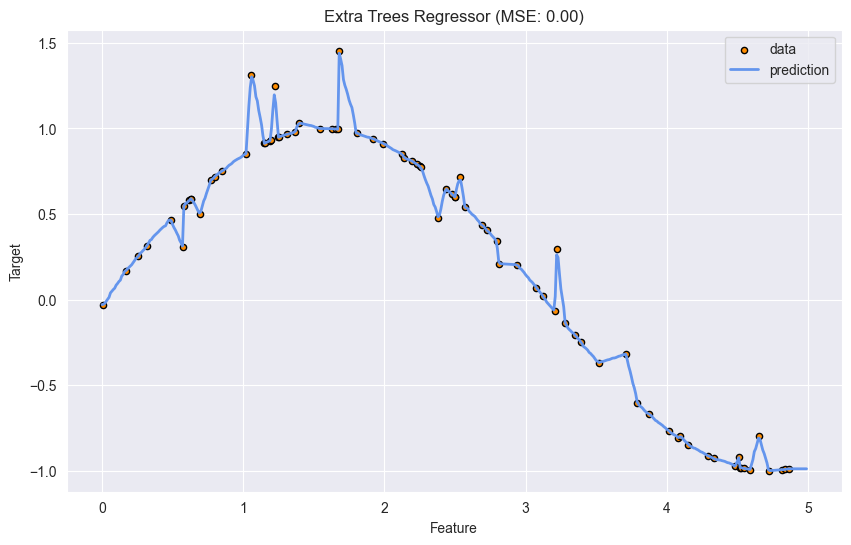

In [9]:
# Train ExtraTreesRegressor
et_regressor = ExtraTreesRegressor(n_estimators=100, random_state=42)
et_regressor.fit(X_reg, y_reg)

# Predict and evaluate
y_pred_et_reg = et_regressor.predict(X_test_reg)
mse_et = mean_squared_error(y_reg, et_regressor.predict(X_reg))

print( hdr )
print( 'Regression' )
print( nwln )

# Plot results
plt.figure( figsize=( 10, 6 ) )
plt.scatter(X_reg, y_reg, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test_reg, y_pred_et_reg, color="cornflowerblue", label="prediction", linewidth=2)
plt.xlabel("Feature")
plt.ylabel("Target")
plt.title(f"Extra Trees Regressor (MSE: {mse_et:.2f})")
plt.legend()
plt.show()

#### Gradient Boosting Classifier


------------------------------------------------------------------------------------------------------------------------

Classifier




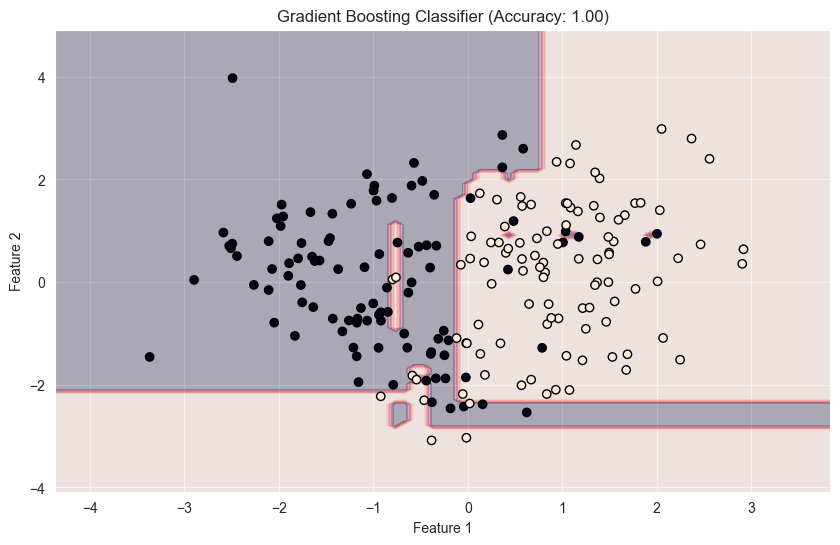

In [10]:
# Train GradientBoostingClassifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_classifier.fit(X_class, y_class)

# Predict and evaluate
y_pred_gb_class = gb_classifier.predict(X_class)
accuracy_gb = accuracy_score(y_class, y_pred_gb_class)

# Plot decision boundary
Z_gb = gb_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z_gb = Z_gb.reshape(xx.shape)

print( hdr )
print( 'Classifier' )
print( nwln )

# Plot results
plt.figure( figsize=( 10, 6 ) )
plt.contourf(xx, yy, Z_gb, alpha=0.3)
plt.scatter(X_class[:, 0], X_class[:, 1], c=y_class, edgecolor='k', marker='o')
plt.title(f"Gradient Boosting Classifier (Accuracy: {accuracy_gb:.2f})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

#### Gradient Boosting Regressor


------------------------------------------------------------------------------------------------------------------------

Regression




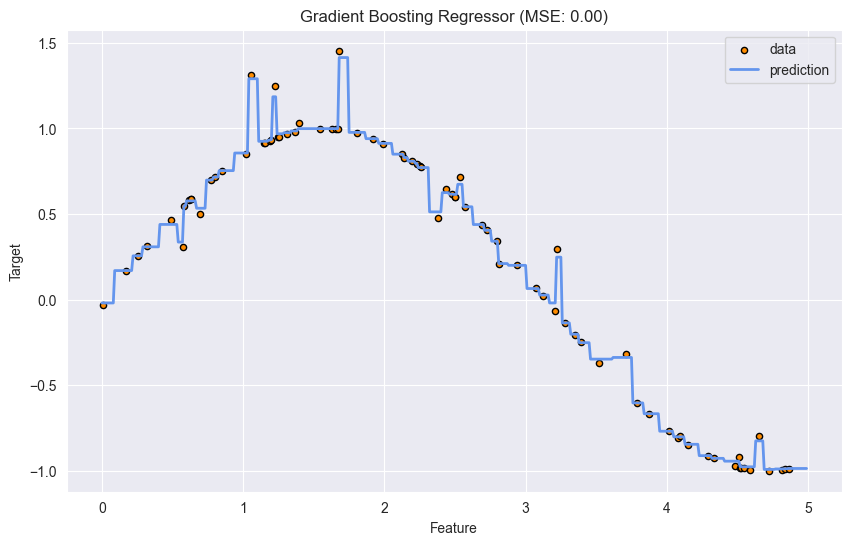

In [11]:
# Train GradientBoostingRegressor
gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_regressor.fit(X_reg, y_reg)

# Predict and evaluate
y_pred_gb_reg = gb_regressor.predict(X_test_reg)
mse_gb = mean_squared_error(y_reg, gb_regressor.predict(X_reg))

print( hdr )
print( 'Regression' )
print( nwln )

# Plot results
plt.figure( figsize=( 10, 6 ) )
plt.scatter(X_reg, y_reg, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test_reg, y_pred_gb_reg, color="cornflowerblue", label="prediction", linewidth=2)
plt.xlabel("Feature")
plt.ylabel("Target")
plt.title(f"Gradient Boosting Regressor (MSE: {mse_gb:.2f})")
plt.legend()
plt.show()

#### Ada Boost Classifier


------------------------------------------------------------------------------------------------------------------------

Classifier




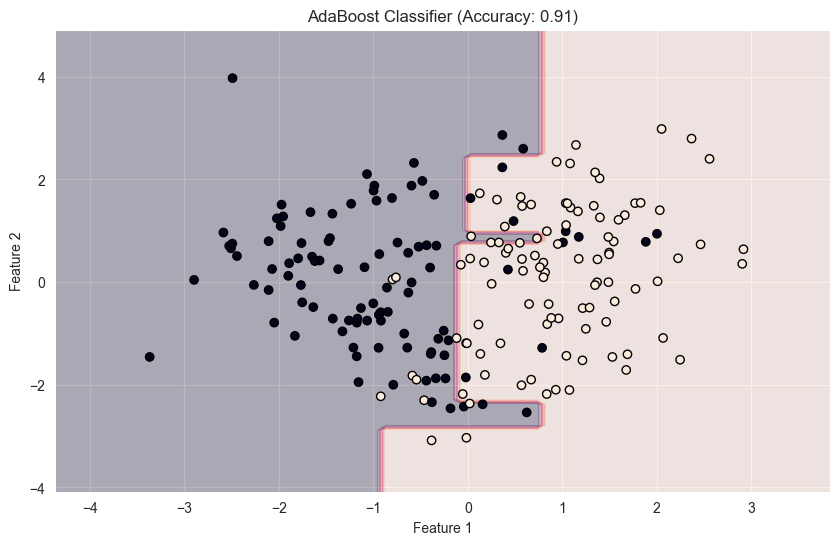

In [12]:
# Train AdaBoostClassifier
ab_classifier = AdaBoostClassifier(n_estimators=100, random_state=42)
ab_classifier.fit(X_class, y_class)

# Predict and evaluate
y_pred_ab_class = ab_classifier.predict(X_class)
accuracy_ab = accuracy_score(y_class, y_pred_ab_class)

# Plot decision boundary
Z_ab = ab_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z_ab = Z_ab.reshape(xx.shape)

print( hdr )
print( 'Classifier' )
print( nwln )

# Plot results
plt.figure( figsize=( 10, 6 ) )
plt.contourf(xx, yy, Z_ab, alpha=0.3)
plt.scatter(X_class[:, 0], X_class[:, 1], c=y_class, edgecolor='k', marker='o')
plt.title(f"AdaBoost Classifier (Accuracy: {accuracy_ab:.2f})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

#### Ada Boost Regressor


------------------------------------------------------------------------------------------------------------------------

Regression




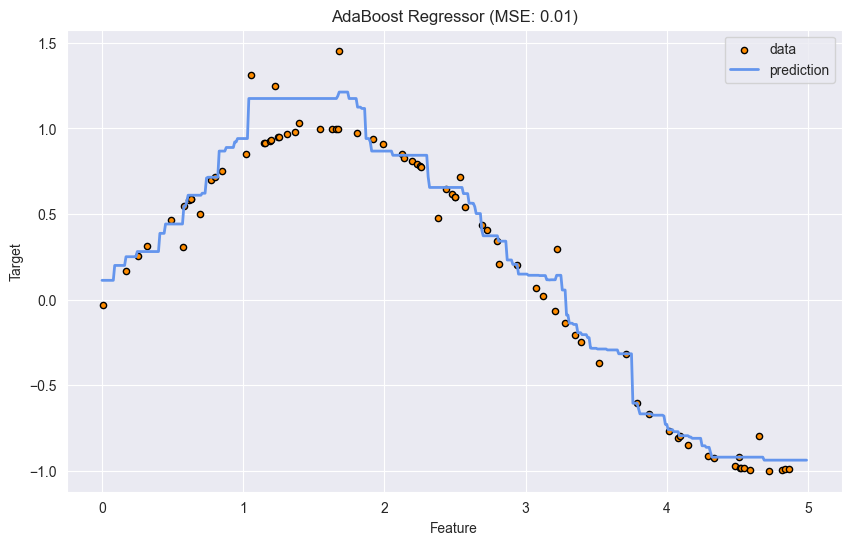

In [13]:
# Train AdaBoostRegressor
ab_regressor = AdaBoostRegressor(n_estimators=100, random_state=42)
ab_regressor.fit(X_reg, y_reg)

# Predict and evaluate
y_pred_ab_reg = ab_regressor.predict(X_test_reg)
mse_ab = mean_squared_error(y_reg, ab_regressor.predict(X_reg))

print( hdr )
print( 'Regression' )
print( nwln )

# Plot results
plt.figure( figsize=( 10, 6 ) )
plt.scatter(X_reg, y_reg, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test_reg, y_pred_ab_reg, color="cornflowerblue", label="prediction", linewidth=2)
plt.xlabel("Feature")
plt.ylabel("Target")
plt.title(f"AdaBoost Regressor (MSE: {mse_ab:.2f})")
plt.legend()
plt.show()

#### Linear Regression


------------------------------------------------------------------------------------------------------------------------

Regression




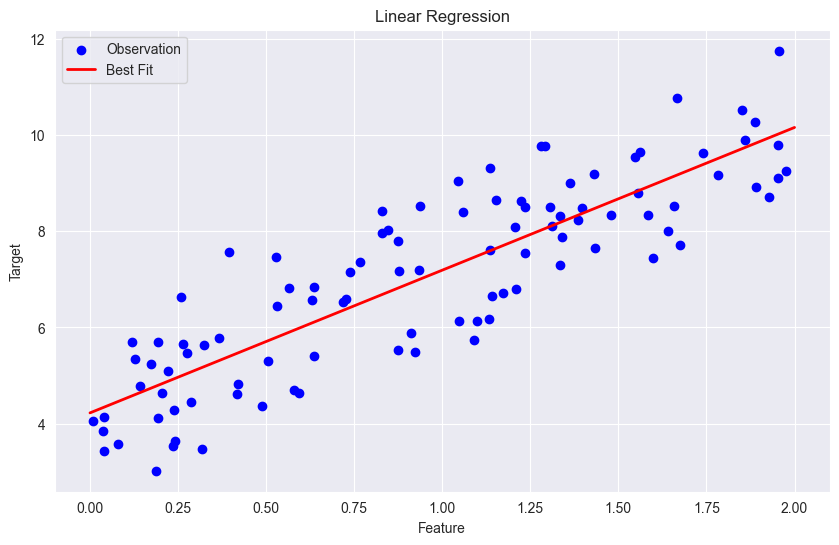

In [14]:
# Generate a synthetic regression dataset
np.random.seed(0)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

# Train Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X, y)

# Predict
X_new = np.array([[0], [2]])
y_prediction = lin_reg.predict(X_new )

print( hdr )
print( 'Regression' )
print( nwln )

# Plot results
plt.figure( figsize=( 10, 6 ) )
plt.scatter(X, y, color='blue', label='Observation')
plt.plot(X_new, y_prediction, color='red', linewidth=2, label='Best Fit' )
plt.xlabel("Feature")
plt.ylabel("Target")
plt.title("Linear Regression")
plt.legend()
plt.show()

### 🔢 Ridge Classifier: Confusion Matrix
- This confusion matrix compares the predicted class labels to the actual class labels.
- The Ridge Classifier was trained to classify values above or below the median as binary classes (1 or 0).
- Diagonal values show correct classifications, while off-diagonal values indicate misclassifications.


------------------------------------------------------------------------------------------------------------------------

Classifier




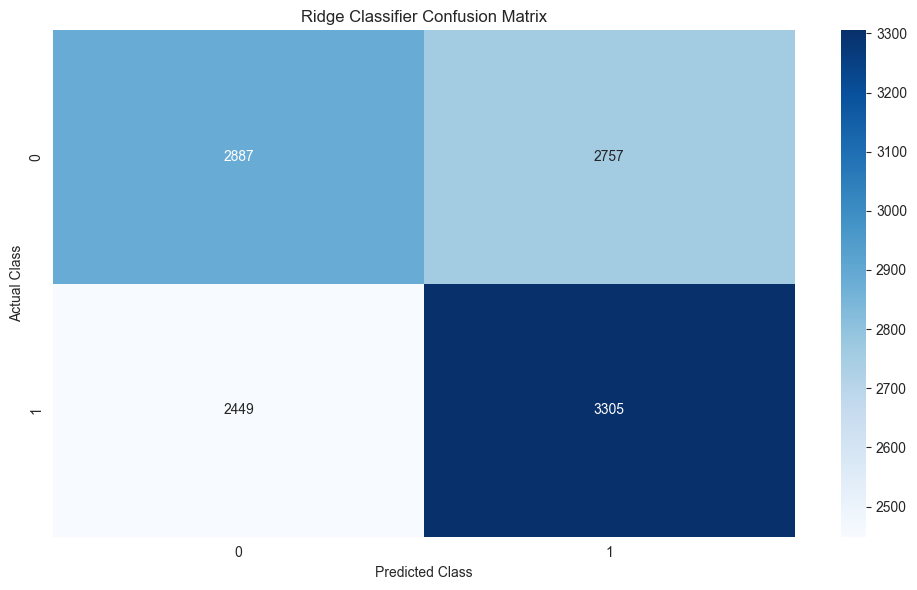

In [15]:
import pandas as pd
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file
file_path =  r'C:\Users\terry\Desktop\Account Balances.xlsx'
xls = pd.ExcelFile(file_path)

# Display sheet names to choose appropriate one
sheet_names = xls.sheet_names

# Load data from the first sheet for this example
df = xls.parse(sheet_names[0])

# Drop rows or columns with excessive NaNs and remove non-numeric columns for modeling
df = df.dropna()
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Ensure there are at least two columns for modeling
if numeric_df.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare data for regression and classification
X = numeric_df.iloc[:, 1:]
y_reg = numeric_df.iloc[:, 0]
y_class = (y_reg > y_reg.median()).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)
_, _, y_train_class, y_test_class = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42)

# Ridge Classifier
ridge_clf = RidgeClassifier(alpha=1.0)
ridge_clf.fit(X_train, y_train_class)
y_pred_class = ridge_clf.predict(X_test)

print( hdr )
print( 'Classifier' )
print( nwln )

# Plot Ridge Classifier
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(y_test_class, y_pred_class), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Ridge Classifier Confusion Matrix")
plt.tight_layout()
plt.show()



### 📊 Ridge Regression: Actual vs. Predicted
- This scatterplot shows the actual values versus the predicted values from the Ridge Regressor.
- The closer the points are to the diagonal, the better the model's prediction performance.


------------------------------------------------------------------------------------------------------------------------

Regression




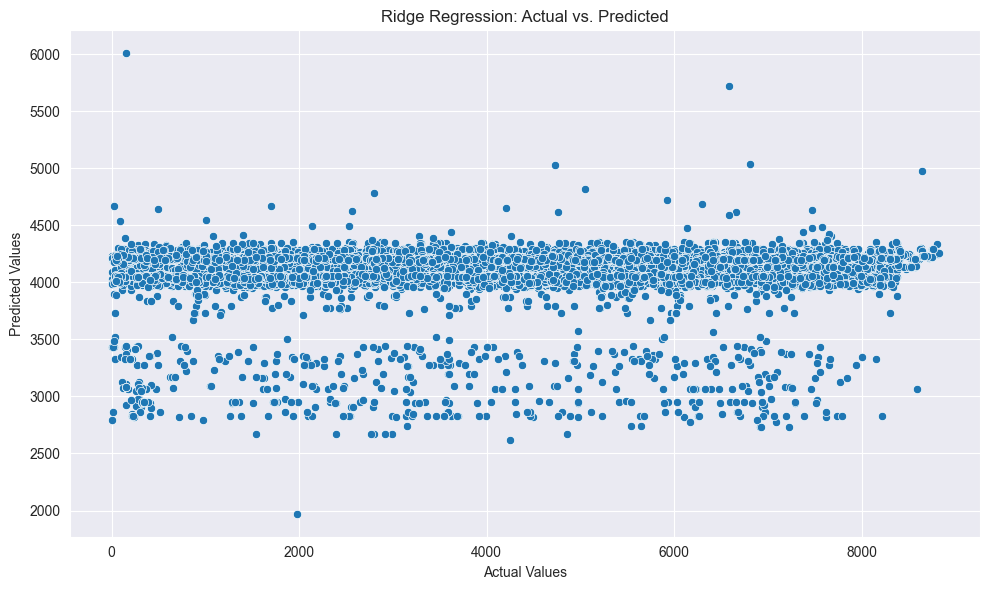

In [16]:
import pandas as pd
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file
file_path =  r'C:\Users\terry\Desktop\Account Balances.xlsx'
xls = pd.ExcelFile(file_path)

# Display sheet names to choose appropriate one
sheet_names = xls.sheet_names

# Load data from the first sheet for this example
df = xls.parse(sheet_names[0])

# Drop rows or columns with excessive NaNs and remove non-numeric columns for modeling
df = df.dropna()
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Ensure there are at least two columns for modeling
if numeric_df.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare data for regression and classification
X = numeric_df.iloc[:, 1:]
y_reg = numeric_df.iloc[:, 0]
y_class = (y_reg > y_reg.median()).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)
_, _, y_train_class, y_test_class = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42)

# Ridge Regression
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train_reg)
y_pred_reg = ridge_reg.predict(X_test)


print( hdr )
print( 'Regression' )
print( nwln )

# Plot Ridge Regression
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_reg, y=y_pred_reg)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Ridge Regression: Actual vs. Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


### 📉 Lasso Regression
- Lasso introduces L1 regularization, promoting sparsity by driving some coefficients to zero.
- Useful for feature selection.


------------------------------------------------------------------------------------------------------------------------





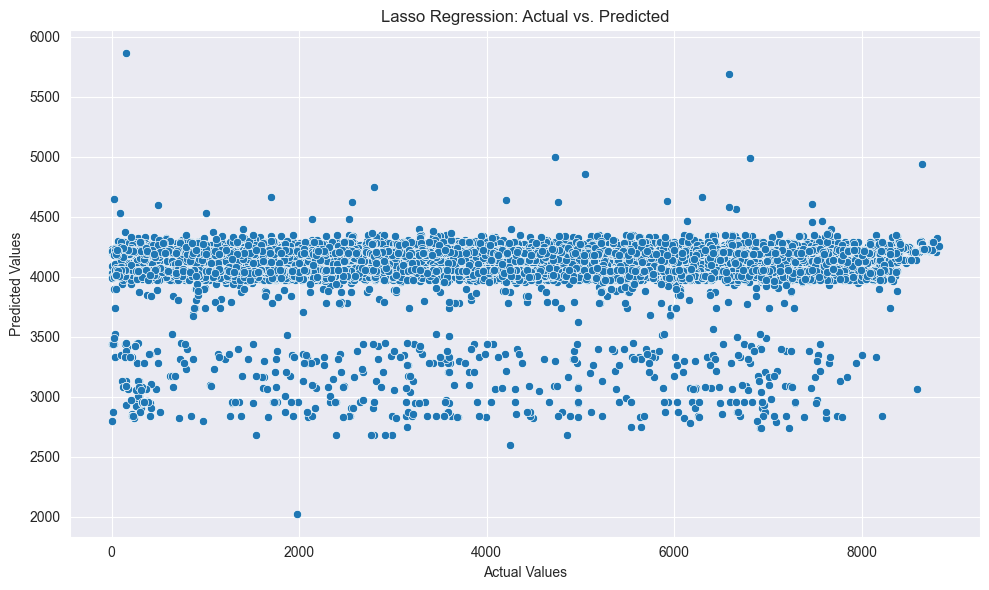

In [20]:
from sklearn.linear_model import Lasso

# Initialize models
models = {
    "Lasso": Lasso(alpha=1.0, max_iter=10000)
}

# Set up a plot for each model
for name, model in models.items():
    model.fit(X_train, y_train_reg)
    y_pred = model.predict(X_test)
    print( hdr )
    print( nwln )
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test_reg, y=y_pred)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{name} Regression: Actual vs. Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### 📉 ElasticNet Regression
- Combines L1 (Lasso) and L2 (Ridge) penalties.
- Balances variable selection and coefficient shrinkage.
- Useful when features are highly correlated.


------------------------------------------------------------------------------------------------------------------------





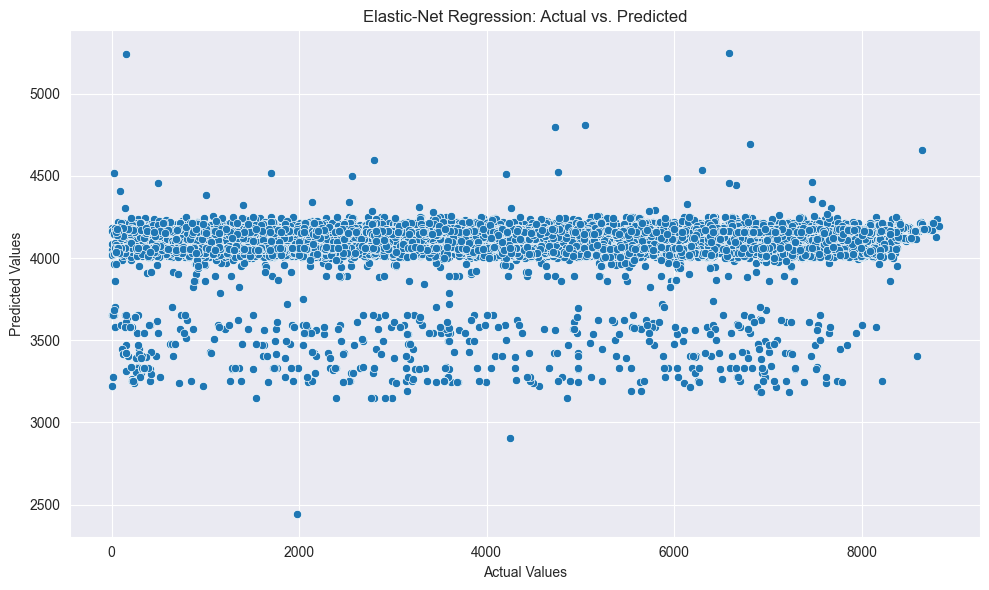

In [51]:
from sklearn.linear_model import ElasticNet


# Initialize models
models = {
	"Elastic-Net": ElasticNet( alpha=1.0, l1_ratio=0.5, max_iter=10000 )
}

# Set up a plot for each model
for name, model in models.items( ):
	model.fit( X_train, y_train_reg )
	y_pred = model.predict( X_test )
	print( hdr )
	print( nwln )
	plt.figure( figsize=(10, 6) )
	sns.scatterplot( x=y_test_reg, y=y_pred )
	plt.xlabel( "Actual Values" )
	plt.ylabel( "Predicted Values" )
	plt.title( f"{name} Regression: Actual vs. Predicted" )
	plt.grid( True )
	plt.tight_layout( )
	plt.show( )

### 📉 Bayesian Ridge Regression
- Uses Bayesian inference to estimate a distribution over the coefficients.
- Provides uncertainty estimates for predictions.
- Often more robust with small datasets.


------------------------------------------------------------------------------------------------------------------------





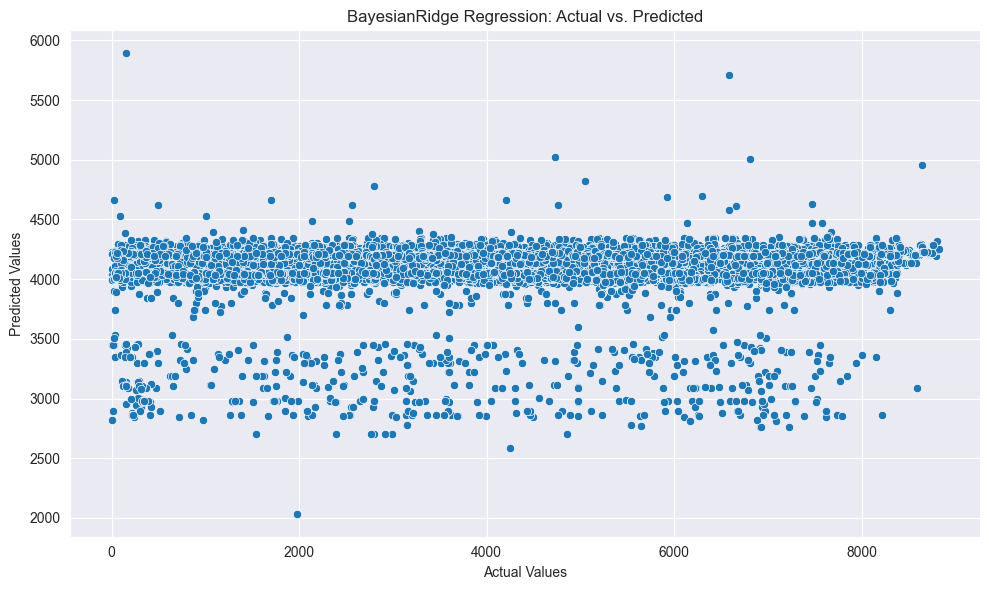

In [22]:
### Linear Models
from sklearn.linear_model import BayesianRidge


# Initialize models
models = {
	"Bayesian Ridge": BayesianRidge( )
}

# Set up a plot for each model
for name, model in models.items( ):
	model.fit( X_train, y_train_reg )
	y_pred = model.predict( X_test )
	print( hdr )
	print( nwln )
	plt.figure( figsize=(10, 6) )
	sns.scatterplot( x=y_test_reg, y=y_pred )
	plt.xlabel( "Actual Values" )
	plt.ylabel( "Predicted Values" )
	plt.title( f"{name} Regression: Actual vs. Predicted" )
	plt.grid( True )
	plt.tight_layout( )
	plt.show( )

### 📉 Huber Regressor
- A robust linear model that is less sensitive to outliers than ordinary least squares.
- Uses a loss function that is quadratic for small errors and linear for large errors.


------------------------------------------------------------------------------------------------------------------------





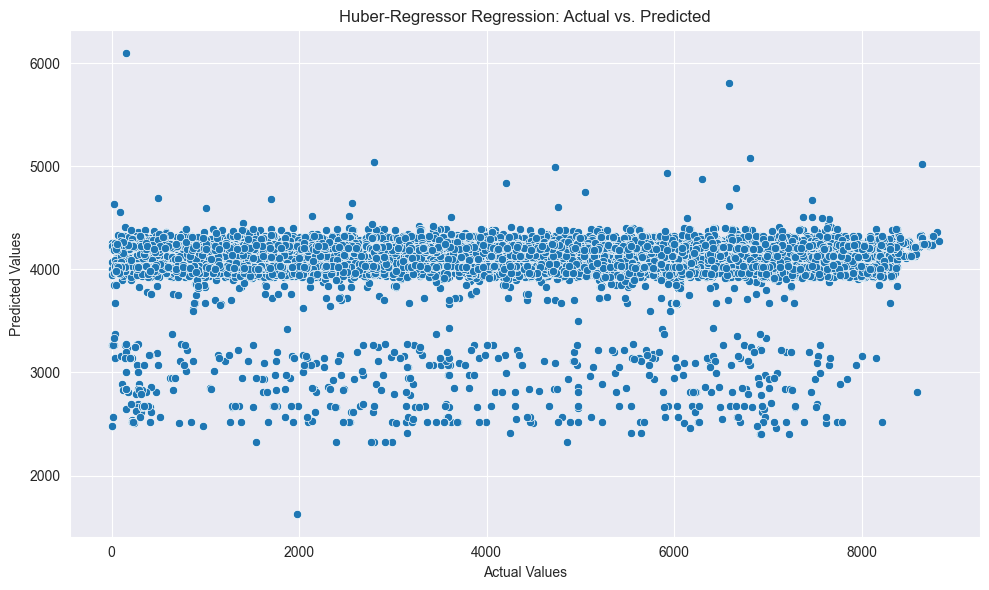

In [35]:
from sklearn.linear_model import HuberRegressor
models = {"Huber-Regressor": HuberRegressor( max_iter=1000 )}

for name, model in models.items( ):
	model.fit( X_train, y_train_reg )
	y_pred = model.predict( X_test )
	print( hdr )
	print( nwln )
	plt.figure( figsize=(10, 6) )
	sns.scatterplot( x=y_test_reg, y=y_pred )
	plt.xlabel( "Actual Values" )
	plt.ylabel( "Predicted Values" )
	plt.title( f"{name} Regression: Actual vs. Predicted" )
	plt.grid( True )
	plt.tight_layout( )
	plt.show( )

### 🔢 SGD Classifier: Confusion Matrix
- This heatmap shows the performance of the SGD Classifier as it attempts to classify values above or below the median.
- Diagonal cells represent correct predictions; off-diagonal cells show misclassifications.


------------------------------------------------------------------------------------------------------------------------

Classifier




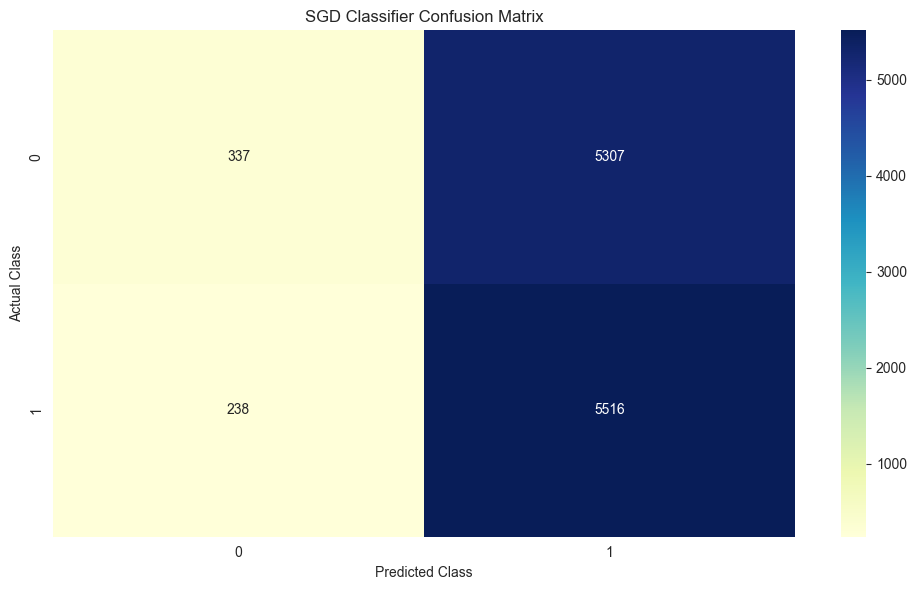

In [34]:
# SGD Classifier

print( hdr )
print( 'Classifier' )
print( nwln )

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train, y_train_class)
y_pred_sgd_clf = sgd_clf.predict(X_test)

# Plot SGD Classifier
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(y_test_class, y_pred_sgd_clf), annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("SGD Classifier Confusion Matrix")
plt.tight_layout()
plt.show()

### 📉 SGD Regressor: Actual vs. Predicted
- This scatterplot displays predicted values against actual values using the Stochastic Gradient Descent Regressor.
- Good for large-scale regression tasks with regularization support (L1, L2).


------------------------------------------------------------------------------------------------------------------------

Regression




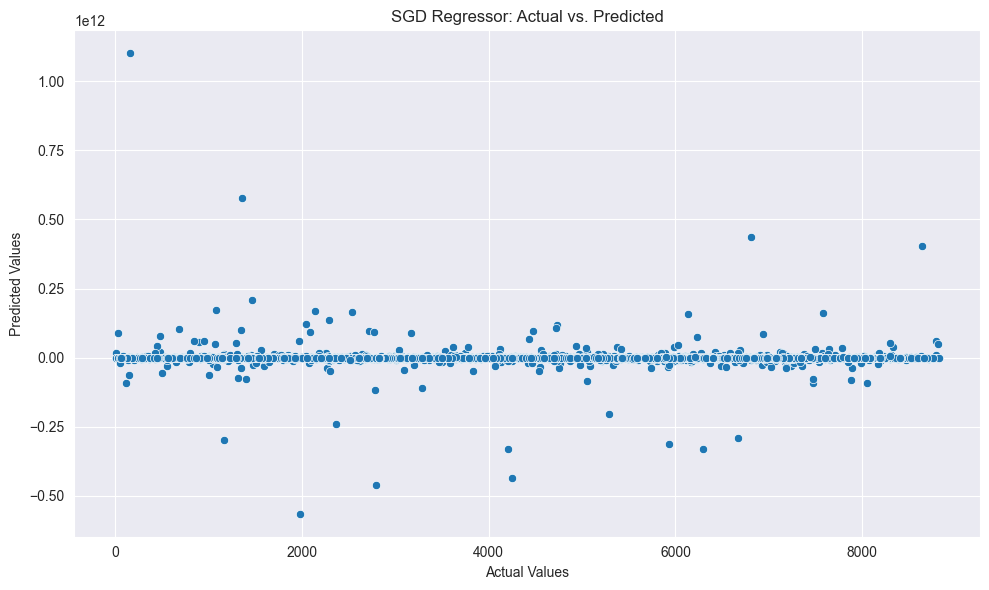

In [33]:
print( hdr )
print( 'Regression' )
print( nwln )

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3)
sgd_reg.fit(X_train, y_train_reg)
y_pred_sgd_reg = sgd_reg.predict(X_test)


# Plot SGD Regressor
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_reg, y=y_pred_sgd_reg)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("SGD Regressor: Actual vs. Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

### 📊 HistGradientBoosting Classifier: Confusion Matrix
- This heatmap visualizes classification performance when predicting whether values fall above or below the median.
- High diagonal counts imply strong classification performance.


------------------------------------------------------------------------------------------------------------------------

Classifier




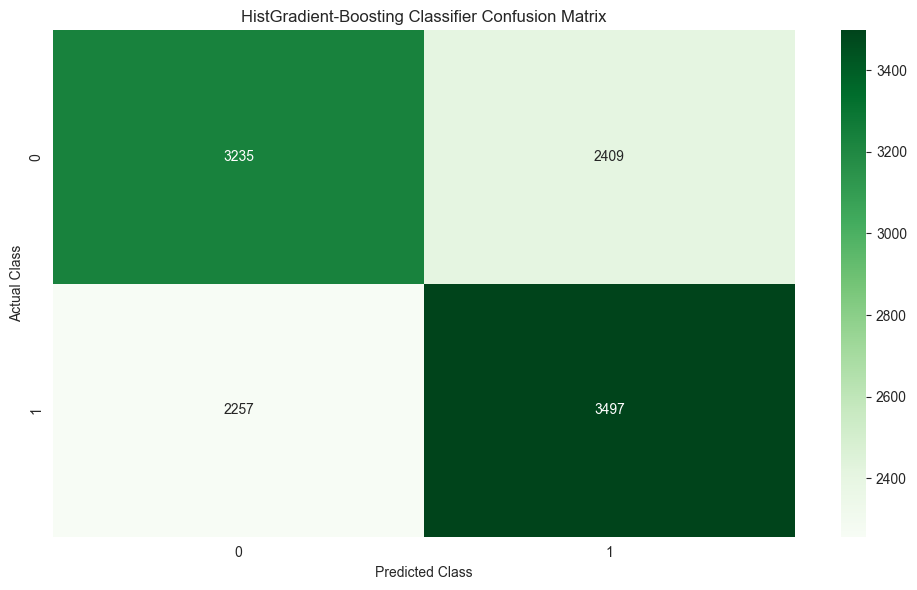

In [37]:
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier

# HistGradientBoosting Classifier
hgb_clf = HistGradientBoostingClassifier(max_iter=100)
hgb_clf.fit(X_train, y_train_class)
y_pred_hgb_clf = hgb_clf.predict(X_test)

print( hdr )
print( 'Classifier' )
print( nwln )

# Plot HistGradientBoosting Classifier
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(y_test_class, y_pred_hgb_clf), annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("HistGradient-Boosting Classifier Confusion Matrix")
plt.tight_layout()
plt.show()


### 📊 Hist Gradient Boosting Regressor: Actual vs. Predicted
- This model applies histogram-based gradient boosting for efficient and scalable regression.
- Ideal for medium to large tabular datasets with strong predictive accuracy.


------------------------------------------------------------------------------------------------------------------------

Regression




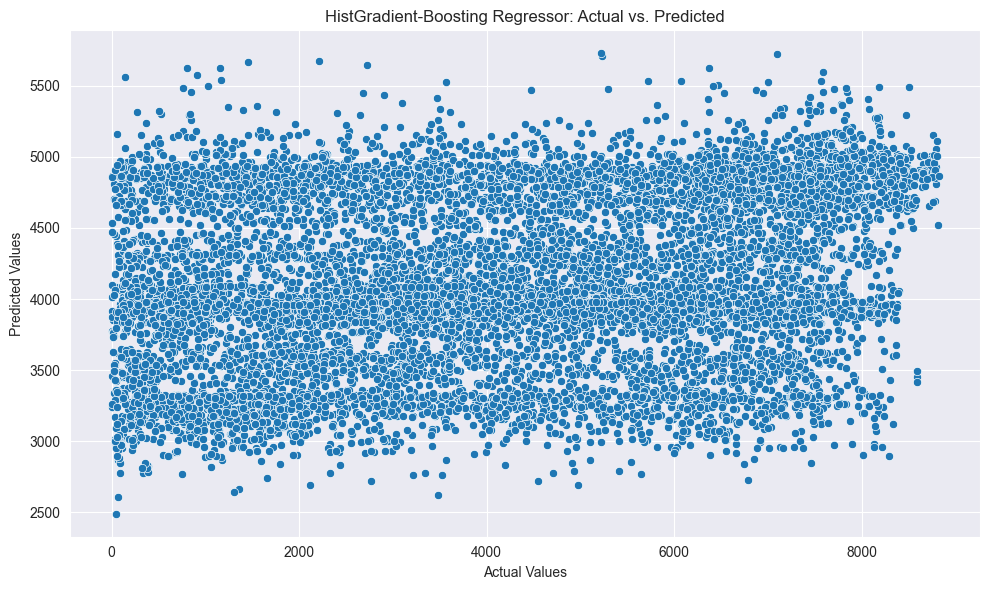

In [40]:
# HistGradientBoosting Regressor
hgb_reg = HistGradientBoostingRegressor(max_iter=100)
hgb_reg.fit(X_train, y_train_reg)
y_pred_hgb_reg = hgb_reg.predict(X_test)

print( hdr )
print( 'Regression' )
print( nwln )

# Plot HistGradientBoosting Regressor
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_reg, y=y_pred_hgb_reg)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("HistGradient-Boosting Regressor: Actual vs. Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

### 🔢 KNeighbors Classifier: Confusion Matrix
- This heatmap shows classification performance, identifying whether a value is above or below the median.
- Each prediction is based on a majority vote from the 5 nearest neighbors.


------------------------------------------------------------------------------------------------------------------------

Classifier




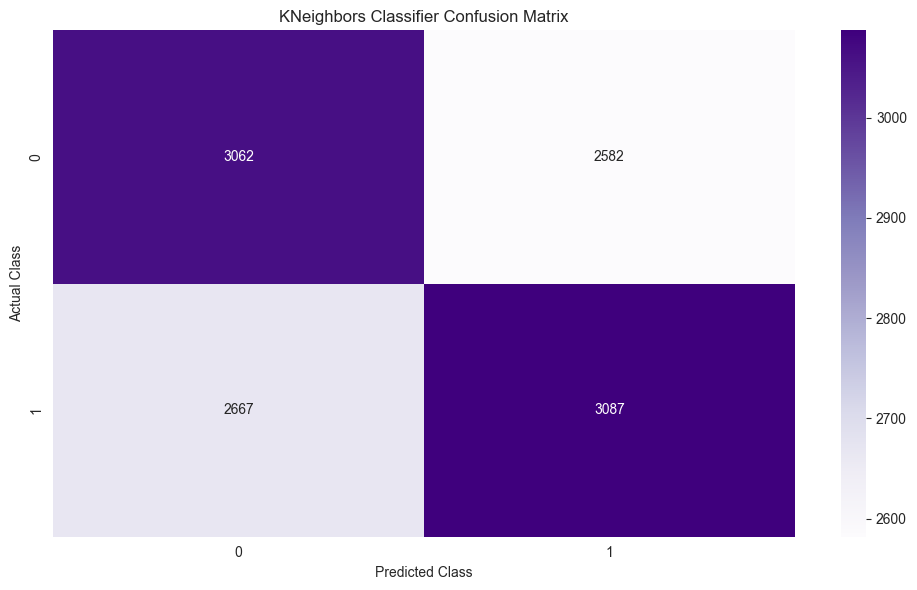

In [41]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train_class)
y_pred_knn_clf = knn_clf.predict(X_test)

print( hdr )
print( 'Classifier' )
print( nwln )

# Plot KNN Classifier
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(y_test_class, y_pred_knn_clf), annot=True, fmt="d", cmap="Purples")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("KNeighbors Classifier Confusion Matrix")
plt.tight_layout()
plt.show()


### 📊 KNeighbors Regressor: Actual vs. Predicted
- This scatterplot compares actual values to the predicted values using a KNN regressor.
- The model makes predictions by averaging the outputs of the 5 nearest data points in feature space.


------------------------------------------------------------------------------------------------------------------------

Regression




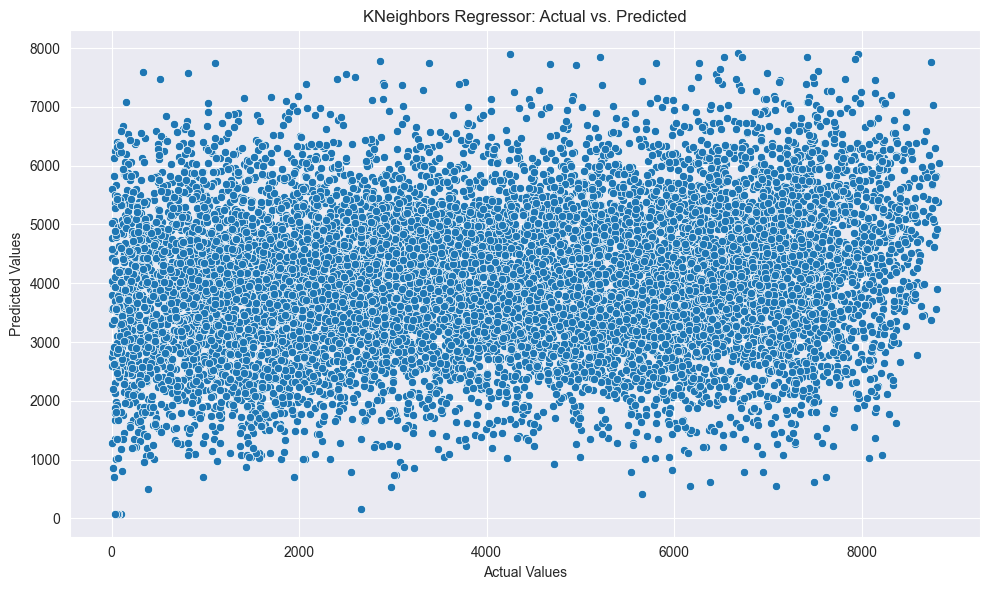

In [27]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor( n_neighbors=5 )
knn_reg.fit( X_train, y_train_reg )
y_pred_knn_reg = knn_reg.predict( X_test )


print( hdr )
print( 'Regression' )
print( nwln )

# Plot KNN Regressor
plt.figure( figsize=( 10, 6 ) )
sns.scatterplot( x=y_test_reg, y=y_pred_knn_reg )
plt.xlabel( "Actual Values" )
plt.ylabel( "Predicted Values" )
plt.title( "K-Neighbors Regressor: Actual vs. Predicted" )
plt.grid( True )
plt.tight_layout( )
plt.show( )


### 🔢 Support Vector Classifier (SVC): Confusion Matrix
- This heatmap visualizes how well SVC classifies values above or below the median.
- SVC constructs hyperplanes in a high-dimensional space to separate the classes.


------------------------------------------------------------------------------------------------------------------------

Classifier




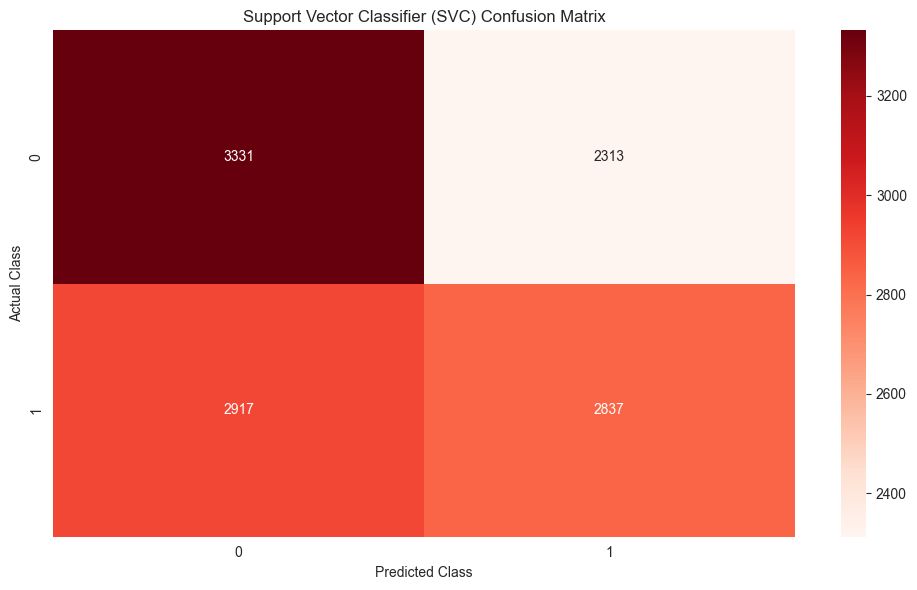

In [43]:
# Support Vector Classifier
svc_model = SVC( kernel='rbf' )
svc_model.fit( X_train, y_train_class )
y_pred_svc = svc_model.predict( X_test )

print( hdr )
print( 'Classifier' )
print( nwln )


# Plot SVC
plt.figure( figsize=( 10, 6 ) )
sns.heatmap( pd.crosstab( y_test_class, y_pred_svc ), annot=True, fmt="d", cmap="Reds" )
plt.xlabel( "Predicted Class" )
plt.ylabel( "Actual Class" )
plt.title( "Support Vector Classifier (SVC) Confusion Matrix" )
plt.tight_layout( )
plt.show( )


### 📈 Support Vector Regressor (SVR): Actual vs. Predicted
- This plot shows how SVR approximates the true values using a non-linear kernel (rbf).
- SVR tries to fit the data within a margin of tolerance rather than minimizing mean squared error directly.


------------------------------------------------------------------------------------------------------------------------

Regression




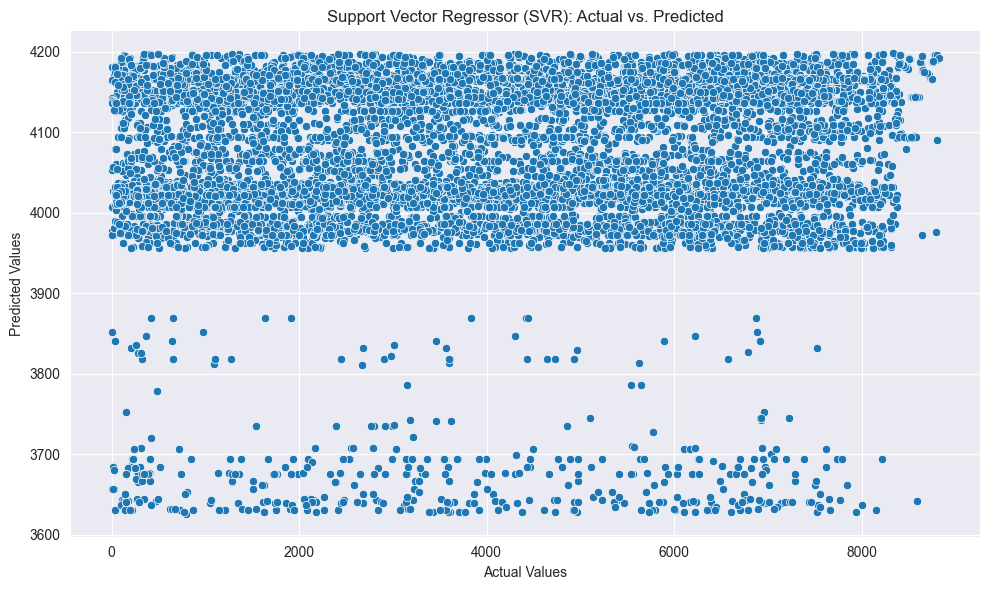

In [44]:
# Support Vector Regressor
svr_model = SVR( kernel='rbf' )
svr_model.fit( X_train, y_train_reg )
y_pred_svr = svr_model.predict( X_test )

print( hdr )
print( 'Regression' )
print( nwln )

# Plot SVR
plt.figure( figsize=( 10, 6 ) )
sns.scatterplot( x=y_test_reg, y=y_pred_svr )
plt.xlabel( "Actual Values" )
plt.ylabel( "Predicted Values" )
plt.title( "Support Vector Regressor (SVR): Actual vs. Predicted" )



plt.grid( True )
plt.tight_layout( )
plt.show( )



### 🧠 MLP Classifier (Adjusted): Confusion Matrix
- Shows how well the MLP Classifier distinguishes values above/below the median.
- Even with early stopping, it achieves a decent classification boundary.


------------------------------------------------------------------------------------------------------------------------

Classifier




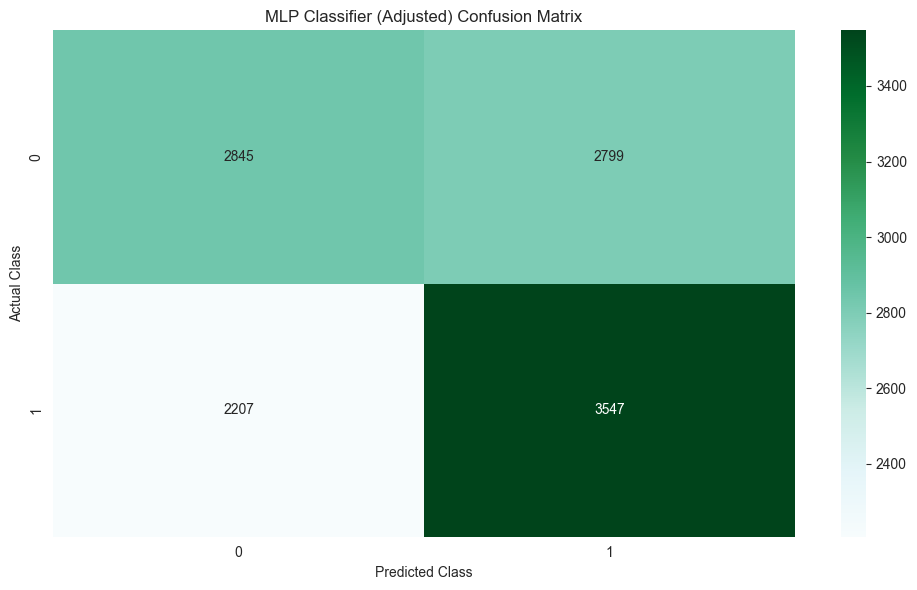

In [45]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, solver='adam', random_state=42)
mlp_clf.fit(X_train, y_train_class)
y_pred_mlp_clf = mlp_clf.predict(X_test)

print( hdr )
print( 'Classifier' )
print( nwln )

# Plot MLP Classifier
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(y_test_class, y_pred_mlp_clf), annot=True, fmt="d", cmap="BuGn")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("MLP Classifier (Adjusted) Confusion Matrix")
plt.tight_layout()
plt.show()

### 🧠 MLP Regressor (Adjusted): Actual vs. Predicted
- The plot shows the predictions of a shallow neural network (1 hidden layer with 50 neurons).
- Although convergence was interrupted, the model offers a rough nonlinear approximation.


------------------------------------------------------------------------------------------------------------------------

Regression




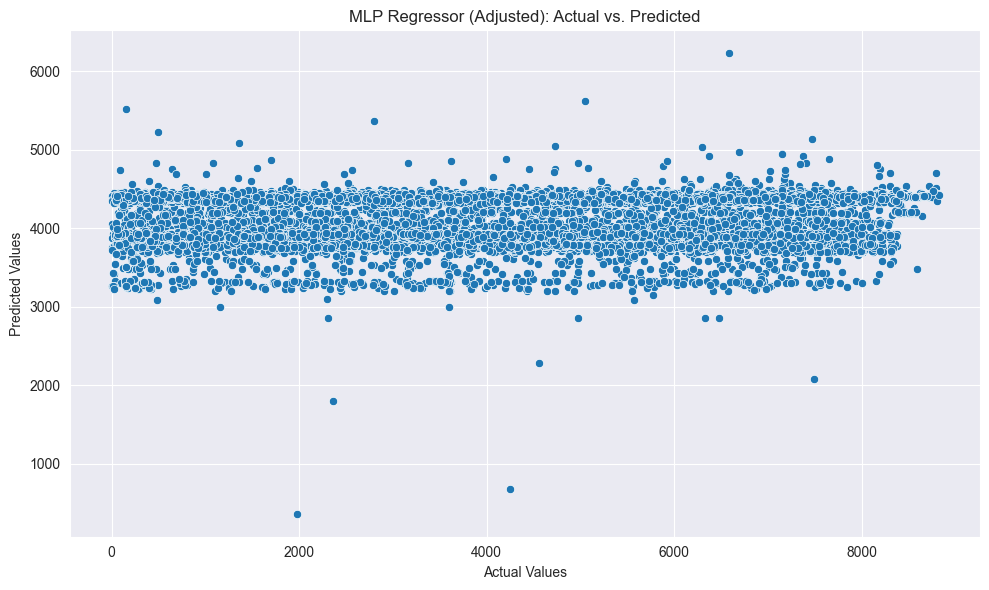

In [46]:
# Retry with simplified model parameters
mlp_reg = MLPRegressor( hidden_layer_sizes=(50,), max_iter=500, solver='adam', random_state=42 )
mlp_reg.fit( X_train, y_train_reg )
y_pred_mlp_reg = mlp_reg.predict( X_test )

print( hdr )
print( 'Regression' )
print( nwln )

# Plot MLP Regressor
plt.figure( figsize=( 10, 6 ) )
sns.scatterplot( x=y_test_reg, y=y_pred_mlp_reg )
plt.xlabel( "Actual Values" )
plt.ylabel( "Predicted Values" )
plt.title( "MLP Regressor (Adjusted): Actual vs. Predicted" )
plt.grid( True )
plt.tight_layout( )
plt.show( )



### 📘 Gaussian Naive Bayes (GaussianNB)
- Assumes features follow a normal (Gaussian) distribution.
- Works well with continuous data.
- The confusion matrix shows how well the model separates values above vs. below the median.


------------------------------------------------------------------------------------------------------------------------

Classifier




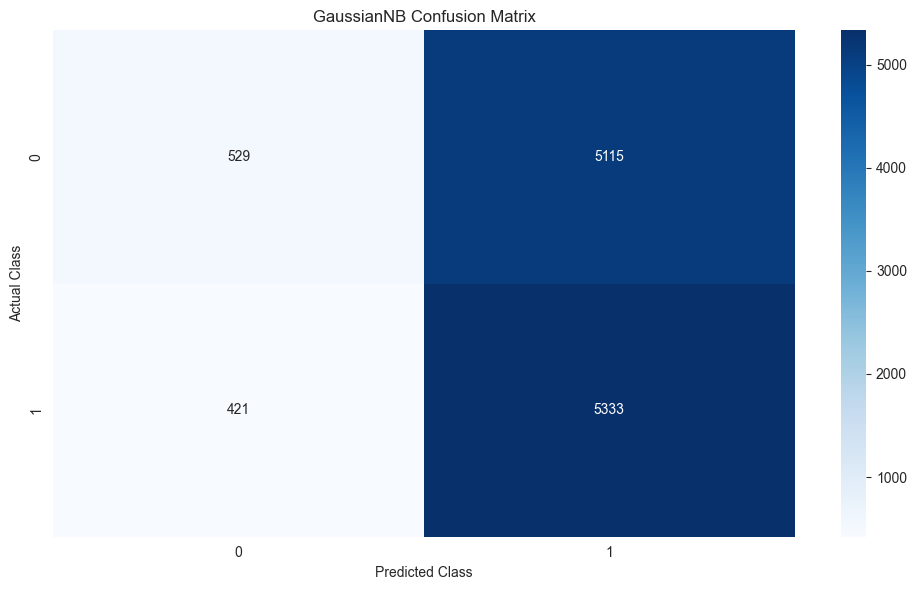

In [47]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB

# Gaussian Naive Bayes Classifier
gnb = GaussianNB( )
gnb.fit( X_train, y_train_class )
y_pred_gnb = gnb.predict( X_test )

print( hdr )
print( 'Classifier' )
print( nwln )

# Plot GaussianNB Classifier
plt.figure( figsize=( 10, 6 ) )
sns.heatmap( pd.crosstab( y_test_class, y_pred_gnb ), annot=True, fmt="d", cmap="Blues" )
plt.xlabel( "Predicted Class" )
plt.ylabel( "Actual Class" )
plt.title( "GaussianNB Confusion Matrix" )
plt.tight_layout( )
plt.show( )


### 🟠 Bernoulli Naive Bayes (BernoulliNB)
- Assumes binary/boolean features (0 or 1).
- Useful for data that can be thresholded into binary states.
- This model may be less appropriate for continuous financial data but is shown for contrast.


------------------------------------------------------------------------------------------------------------------------

Classifier




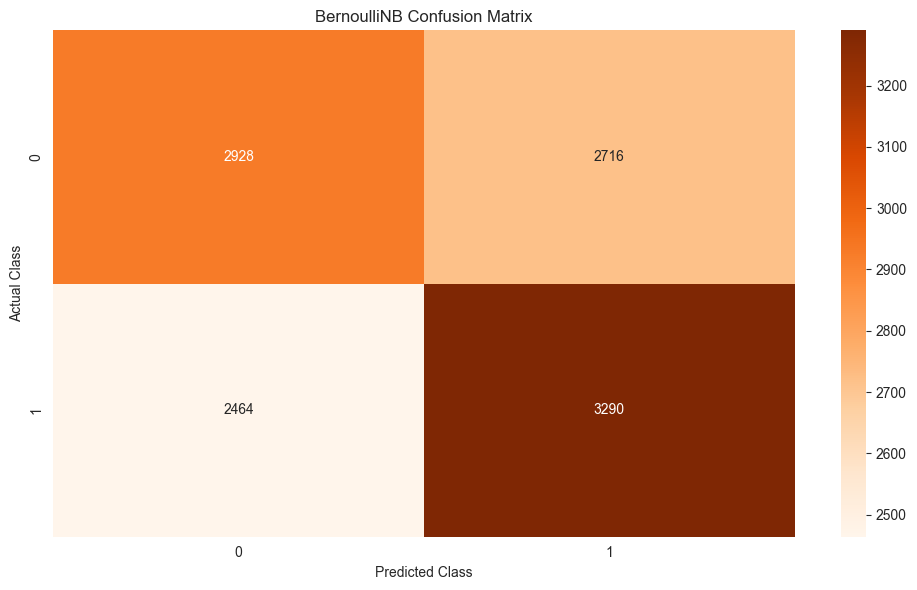

In [48]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB

# Bernoulli Naive Bayes Classifier
bnb = BernoulliNB( )
bnb.fit( X_train, y_train_class )
y_pred_bnb = bnb.predict( X_test )

print( hdr )
print( 'Classifier' )
print( nwln )

# Plot BernoulliNB Classifier
plt.figure( figsize=( 10, 6 ) )
sns.heatmap( pd.crosstab(y_test_class, y_pred_bnb ), annot=True, fmt="d", cmap="Oranges" )
plt.xlabel( "Predicted Class" )
plt.ylabel( "Actual Class" )
plt.title( "BernoulliNB Confusion Matrix" )
plt.tight_layout( )
plt.show( )


### 📌 KMeans Clustering (2D PCA Projection)
- Groups data into 2 clusters using distance-based centroids.
- Visualization uses PCA to reduce dimensions for 2D plotting.
- Points are colored by their assigned cluster labels.




------------------------------------------------------------------------------------------------------------------------

Classifier




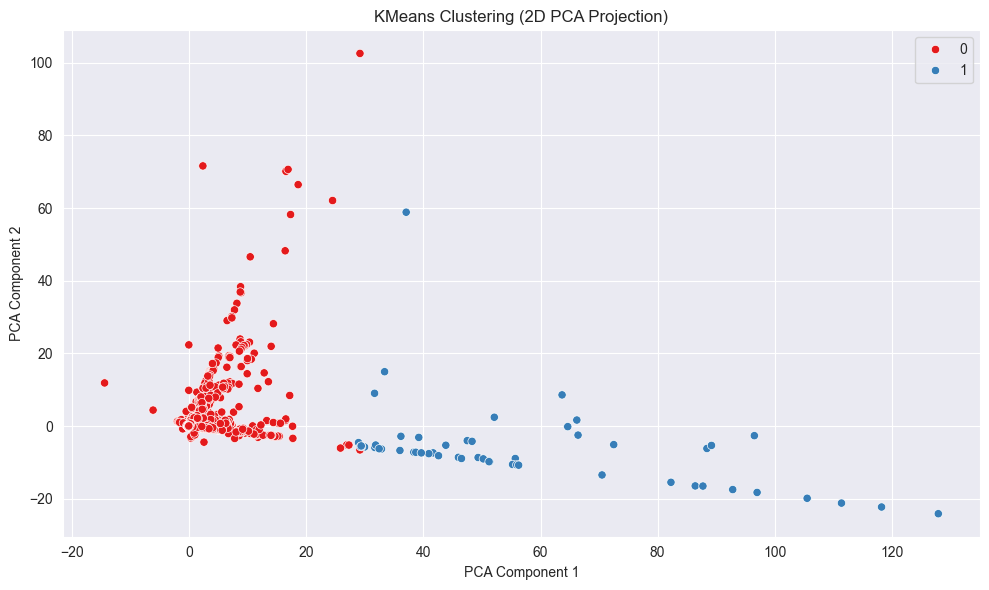

In [49]:
from sklearn.cluster import KMeans, DBSCAN

# Reduce dimensionality for visualization (PCA)
from sklearn.decomposition import PCA

# Apply PCA to reduce data to 2 dimensions for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# KMeans Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

print( hdr )
print( 'Classifier' )
print( nwln )

# Plot KMeans clustering result
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette="Set1", legend="full")
plt.title("KMeans Clustering (2D PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


### 📌 DBSCAN Clustering (2D PCA Projection)
- A density-based clustering algorithm that groups closely packed points and labels outliers as -1.
- Does not require specifying the number of clusters in advance.
- More robust to irregular cluster shapes and noise.

In [50]:
# Apply PCA to reduce data to 2 dimensions for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

print( hdr )
print( 'Classifier' )
print( nwln )

# Plot DBSCAN clustering result
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=dbscan_labels, palette="Set2", legend="full")
plt.title("DBSCAN Clustering (2D PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


MemoryError: 